# Example: Obsid 8008 #

In [1]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from Quaternion import Quat
from astropy.table import Table
import Ska.Numpy
from Ska.engarchive import fetch_sci as fetch
from mica.archive.aca_l0 import get_l0_images, get_slot_data
from mica.archive import asp_l1
from Chandra.Time import DateTime
from Ska.Matplotlib import plot_cxctime
import cxotime
from chandra_aca.aca_image import ACAImage
from kadi import events
import mica.starcheck
from chandra_aca.transform import pixels_to_yagzag, yagzag_to_pixels, mag_to_count_rate, count_rate_to_mag
from Ska.quatutil import yagzag2radec, radec2yagzag
from agasc.agasc import get_agasc_cone

In [2]:
# local imports:
import sys
sys.path.append(".")
import aca_simulate as sim
reload(sim)
from aca_simulate import ImgList

/proj/sot/ska/arch/x86_64-linux_CentOS-5/lib/python2.7/site-packages/mica/archive/aca_dark/dark_model.py:2: DeprecationWarning: mica.archive.aca_dark.dark_model is deprecated.  See chandra_aca.dark_model
  warnings.warn("mica.archive.aca_dark.dark_model is deprecated.  See chandra_aca.dark_model", DeprecationWarning)

  warnings.warn("mica.archive.aca_dark.dark_model is deprecated.  See chandra_aca.dark_model", DeprecationWarning)



In [3]:
def get_telem(cat, slot):
    ok = (cat['slot'] == slot) * ((cat['type'] == 'BOT') + (cat['type'] == 'GUI'))
    yag, zag = cat['yang'][ok][0], cat['zang'][ok][0]
    mag, maxmag = cat['mag'][ok][0], cat['maxmag'][ok][0]
    return yag, zag, mag, maxmag


def as_array(attr, imgs):
    out = np.array([getattr(img, attr) for img in imgs])
    return out


def plot_star(star, c32=True, cbar=True):
    plt.imshow(star, interpolation='none', cmap='hot', vmin = -100, vmax=2300, origin='lower')
    if cbar:
        plt.colorbar()
    plt.hlines(np.arange(0.5, 7.5), -0.5, 7.5, colors='y', linestyles='dotted')
    plt.vlines(np.arange(0.5, 7.5), -0.5, 7.5, colors='y', linestyles='dotted')
    if c32:
        c32 = np.array([1, 2, 2, 6, 6, 7, 7, 6, 6, 2, 2, 1, 1]) - 0.5
        r32 = np.array([2, 2, 1, 1, 2, 2, 6, 6, 7, 7, 6, 6, 2]) - 0.5
        if star.shape == (6, 6):
            r32 = r32 - 1
            c32 = c32 - 1
        plt.plot(c32, r32, '-', lw=2, color='w')
    plt.xlim(-0.5, 7.5)
    plt.ylim(-0.5, 7.5)
    plt.ylabel('Row')
    plt.xlabel('Column')
    plt.title('(ROW0, COL0) = ({:.0f}, {:.0f})'.format(row0, col0))
    return


def plot_set(imgs, start, vmin=-10, vmax=2000, num=4, grid6x6=False):
    for i in np.arange(start, start + num):
        plt.subplot(1, num, i - start + 1)
        plt.imshow(imgs[i], interpolation='none', origin='lower',
                   cmap='hot', vmin=vmin, vmax=vmax)
        if grid6x6:
            plt.hlines(np.arange(0.5, 5.5), -0.5, 5.5, colors='y', linestyles='dotted')
            plt.vlines(np.arange(0.5, 5.5), -0.5, 5.5, colors='y', linestyles='dotted')
        plt.xlabel('Column (px)')
        plt.ylabel('Row (px)')
    return


def centroids(img):
    if img.shape == (8, 8):
        img = img[ACAImage(row0=img.row0 + 1, col0=img.col0 + 1, shape=(6, 6))]
    rw, cw = np.mgrid[0:6, 0:6] + 0.5
    img[[0, 0, 5, 5], [0, 5, 0, 5]] = 0.
    norm = np.sum(img)
    r = np.sum(rw * img) / norm
    c = np.sum(cw * img) / norm
    return np.float(r), np.float(c)


class ObcAca(object):
    def __init__(self, start, stop, slot):
        self.yags = fetch.Msid('aoacyan{}'.format(slot), start, stop)
        self.zags = fetch.Msid('aoaczan{}'.format(slot), start, stop)
        self.funcs = fetch.Msid('aoacfct{}'.format(slot), start, stop)
        self.seqs = fetch.Msid('aoacaseq'.format(slot), start, stop)
        self.mags = fetch.Msid('aoacmag{}'.format(slot), start, stop)
        self.defpix = fetch.Msid('aoacidp{}'.format(slot), start, stop)
        self.multstars = fetch.Msid('aoacims{}'.format(slot), start, stop)
        self.t_aca = fetch.Msid('aach1t', start, stop)
        self.t_aca = np.mean(self.t_aca.vals)
        self.ok = (self.yags.vals > -3200) & (self.zags.vals > -3200)
        self.imgs = get_l0_images(start, stop, slot=slot,
                                   columns=['IMGROW0', 'IMGCOL0', 'BGDAVG', 'TIME'])
        self.row0s = as_array('IMGROW0', self.imgs)
        self.col0s = as_array('IMGCOL0', self.imgs)
        self.bgdavgs = as_array('BGDAVG', self.imgs)
        self.times = as_array('TIME', self.imgs)
        
    def __getattr__(imgs, attr):
        return np.array([getattr(img, attr) for img in imgs])
    

def plot_true_yags_zags(nstop, times, true_yags, true_zags, obc_yags, obc_zags):
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plot_cxctime(times[:nstop], true_yags[:nstop], 'b', alpha=0.3, lw=5)
    plot_cxctime(times[:nstop], obc_yags[:nstop], 'k', lw=1.5)
    plt.ylabel('True yags')
    plt.xlabel('Time')
    plt.ylim(obc_yags[0] - 20, obc_yags[0] + 20);
    plt.subplot(1, 2, 2)
    plot_cxctime(times[:nstop], true_zags[:nstop], 'b', alpha=0.3, lw=5, label='True')
    plot_cxctime(times[:nstop], obc_zags[:nstop], 'k', label='OBC', lw=1.5)
    plt.ylabel('True zags');
    plt.xlabel('Time')
    plt.ylim(obc_zags[0] - 20, obc_zags[0] + 20)
    plt.legend();
    return


def get_true_yags_zags(n, yag, zag, quat):
    true_yags = np.zeros(n)
    true_zags = np.zeros(n)
    quats = [quat]
    true_yags[0] = yag
    true_zags[0] = zag
    ra, dec = yagzag2radec(yag / 3600., zag / 3600., quat) # pointing, not the star

    for ii in range(1, n):
        dyaw, dpitch = yaw[ii] - yaw[0], pitch[ii] - pitch[0]
        dq = Quat([dyaw / 3600., -dpitch / 3600., 0.])
        quats.append(quat * dq)
        y, z = radec2yagzag(ra, dec, quats[-1])
        true_yags[ii] = y * 3600.
        true_zags[ii] = z * 3600.

    return true_yags, true_zags


def plot_guide_summary(guide):
    plt.figure(figsize=(13, 26))

    plt.subplot(6, 1, 1)

    plt.plot(guide['time'] - guide['time'][0], guide['true_yags'], 'b', lw=5, alpha=0.5, label='true')
    plt.plot(obc.yags.times[1::2] - obc.yags.times[1], obc.yags.vals[1::2], 'k', label='OBC')
    plt.plot(guide['time'] - guide['time'][0], guide['aca_yags'], 'c', lw=5, alpha=0.5, label='sim')
    plt.legend()
    plt.ylabel('Yags')
    plt.xlim(0, 1300)
    plt.ylim(yag - 20, yag + 20);

    plt.subplot(6, 1, 2)

    plt.plot(obc.times - obc.times[0], obc.row0s, 'k', label='OBC')
    plt.plot(guide['time'] - guide['time'][0], guide['row0s'], 'c', lw=5, alpha=0.5, label='sim')
    plt.legend()
    plt.ylabel('ROW0')
    plt.xlim(0, 1300)
    plt.margins(0.05);

    plt.subplot(6, 1, 3)

    plt.plot(guide['time'] - guide['time'][0], guide['true_zags'] + pitch[0], 'b', lw=5, alpha=0.5)
    plt.plot(obc.zags.times[1::2] - obc.zags.times[1], obc.zags.vals[1::2], 'k')
    plt.plot(guide['time'] - guide['time'][0], guide['aca_zags'], 'c', lw=5, alpha=0.5)
    plt.ylabel('Zags')
    plt.xlim(0, 1300)
    plt.ylim(zag - 20, zag + 20);

    plt.subplot(6, 1, 4)

    plt.plot(obc.times - obc.times[0], obc.col0s, 'k', label='OBC')
    plt.plot(guide['time'] - guide['time'][0], guide['col0s'], 'c', lw=5, alpha=0.5, label='sim')
    plt.legend()
    plt.ylabel('COL0')
    plt.xlim(0, 1300)
    plt.margins(0.05);

    plt.subplot(6, 1, 5)

    plt.plot(obc.times - obc.times[0], obc.bgdavgs, 'k', label='OBC')
    plt.plot(guide['time'] - guide['time'][0], guide['bgdavgs'], 'c', lw=5, alpha=0.5, label='sim')
    plt.ylabel('BGDAVG')
    plt.legend()
    plt.xlim(0, 1300)
    plt.ylim(0, 15);

    plt.subplot(6, 1, 6)

    plt.plot(obc.mags.times - obc.mags.times[0], obc.mags.vals, 'k', label='OBC')
    plt.plot(guide['time'] - guide['time'][0], guide['aca_mags'], 'c', lw=5, alpha=0.5, label='sim')
    plt.ylabel('MAGS')
    plt.legend()
    plt.xlim(0, 1300)
    plt.ylim(mag - 0.2, mag + 0.5);
    
    return

## FWHM ##

For FWHM of a typical ACA star assume value derived using Level-0 data, <code>FWHM = 2.77 pixels</code>. See fwhm.ipynb.

## Constants ###

In [4]:
FWHM = 2.77
GAIN = 5.
INTEG = 1.696

<img src='ACAImage-coordinates.jpg'>

##Obsid 8008##

In [5]:
obsid = 8008
d = events.dwells.filter(obsid=obsid)[0]
slot = 6
obc = ObcAca(d.start, d.stop, slot=slot)
sc = mica.starcheck.get_starcheck_catalog_at_date(d.start)
quat_cat = Quat([sc['manvr']['target_Q{}'.format(i)][0] for i in (1, 2, 3, 4)])
cat = sc['cat']
obs = sc['obs']
dither = {'dither_y_amp': obs['dither_y_amp'], 'dither_z_amp': obs['dither_z_amp'],
          'dither_y_period': obs['dither_y_period'], 'dither_z_period': obs['dither_z_period'],
          'dither_y_phase': 0., 'dither_z_phase': 0.}
quat_cat

<Quat q1=0.14961427 q2=0.49089671 q3=0.83147065 q4=0.21282047>

In [6]:
# On-board quaternion
atts = fetch.MSIDset(['aoattqt*'], d.start, d.stop)
quat_obc = Quat([atts['aoattqt{}'.format(i + 1)].vals[0] for i in range(4)])
quat_obc

<Quat q1=0.14960202 q2=0.49089972 q3=0.83147544 q4=0.21280339>

In [7]:
yag_cat, zag_cat, mag, maxmag = get_telem(cat, slot)
print('Slot {}, guiding on star with:'.format(slot))
print('yag = {:.0f}, zag = {:.0f}, mag = {:.3f}, maxmag = {:.3f}'.format(yag_cat, zag_cat, mag, maxmag))

Slot 6, guiding on star with:
yag = 890, zag = -1600, mag = 8.641, maxmag = 10.141


In [8]:
obc.mags.times[1] - obc.mags.times[0], obc.mags.times[1]

(1.0250000357627869, 284100554.51001441)

In [9]:
obc.times[1] - obc.times[0], obc.times[0]

(2.0500001311302185, 284100554.68701398)

In [10]:
atts['aoattqt1'].times[0]

284100553.48501438

In [11]:
obc.yags.vals[:10], obc.yags.vals[1::2][:5]

(array([ 887.075,  887.175,  887.175,  887.2  ,  887.2  ,  887.275,
         887.275,  887.4  ,  887.4  ,  887.45 ]),
 array([ 887.175,  887.2  ,  887.275,  887.4  ,  887.45 ]))

### Match dither phase ###

OBC telemetry at t=0 is in a random phase. 'Fit' for phase.

In [12]:
yag_cat - obc.yags.vals[0], zag_cat - obc.zags.vals[0], 'px'

(2.9249999999999545, -7.9749999999999091, 'px')

In [13]:
if np.any([dither[key] == None for key in dither.keys()]):
    dither = {'dither_y_amp': 8., 'dither_z_amp': 8.,
              'dither_y_period': 1000., 'dither_z_period': 707.,
              'dither_y_phase': 0., 'dither_z_phase': 0.}
print(dither)

{'dither_z_phase': 0.0, 'dither_y_phase': 0.0, 'dither_y_period': 1000.0, 'dither_z_amp': 8.0, 'dither_z_period': 707.1, 'dither_y_amp': 8.0}


In [14]:
reload(sim)
dither['dither_y_phase'] = -0.14 # fraction of 2pi
dither['dither_z_phase'] = 0.415
yaw = sim.calc_dither(obc.yags.times[1::2], dither, 'y')
pitch = sim.calc_dither(obc.yags.times[1::2], dither, 'z')
  
yaw[0], pitch[0], 'arcsec'

(4.0935115201127861, 5.6703603420208397, 'arcsec')

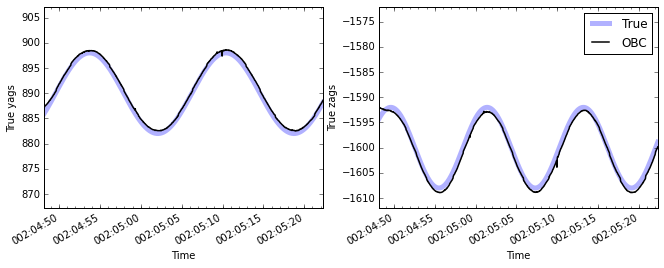

In [15]:
nstop = 1000
n = len(obc.yags.times[1::2][:nstop])
true_yags, true_zags = get_true_yags_zags(n, yag_cat, zag_cat, quat_cat)

plot_true_yags_zags(nstop, obc.yags.times[1::2],
                    true_yags - yaw[0], true_zags + pitch[0],
                    obc.yags.vals[1::2], obc.zags.vals[1::2])

### Simulate a single star ###

In [17]:
reload(sim)
sz = 6
row0 = obc.row0s[0]
col0 = obc.col0s[0]

# OBC
star_obc = obc.imgs[0] - obc.bgdavgs[0]

# Simulation 1: star parameters from telemetry
ra1, dec1 = yagzag2radec(obc.yags.vals[0] / 3600., obc.zags.vals[0] / 3600., quat_obc)
mag1 = obc.mags.vals[0]
star1 = sim.simulate_star(quat_obc, ra1, dec1, mag1, row0, col0, sz)

# Simulation 2: star parameters from catalog
ra2, dec2 = yagzag2radec(yag_cat / 3600., zag_cat / 3600., quat_cat)
star2 = sim.simulate_star(quat_cat, ra2, dec2, mag, row0, col0, sz)

# Simulation 3: star (mag, quat) from catalog, (yag, zag) - phase corrected
yag = yag_cat - yaw[0]
zag = zag_cat + pitch[0]
dq = Quat([yaw[0] / 3600., -pitch[0] / 3600., 0.])
quat = quat_cat * dq
ra3, dec3 = yagzag2radec(yag / 3600., zag / 3600., quat)
star3 = sim.simulate_star(quat, ra3, dec3, mag, row0, col0, sz)

which,r,c,dyag,dzag,dr,dc
string80,float32,float32,float32,float32,float32,float32
OBC img.,3.239,3.387,0.000,0.000,0.000,0.000
Telemetry,3.218,3.351,0.000,0.000,-0.021,-0.037
Catalog,2.689,1.952,2.925,-7.975,-0.550,-1.435
Phase corr,3.424,2.929,-1.169,-2.305,0.185,-0.458


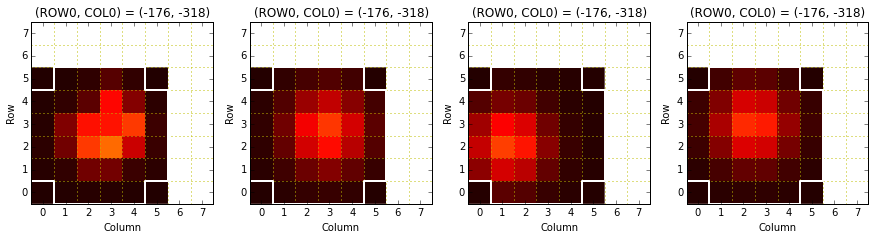

In [18]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
plot_star(star_obc, cbar=False)
plt.subplot(1, 4, 2)
plot_star(star1, cbar=False)
plt.subplot(1, 4, 3)
plot_star(star2, cbar=False)
plt.subplot(1, 4, 4)
plot_star(star3, cbar=False)

row_obc, col_obc = yagzag_to_pixels(obc.yags.vals[0], obc.zags.vals[0])
r_obc = row_obc - row0
c_obc = col_obc - col0

tab = Table(names=('which', 'counts', 'mag', 'r', 'c', 'dyag', 'dzag', 'dr', 'dc'),
            dtype=('S10', 'i4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4'))

counts_obc = np.sum(obc.imgs[0]) - 32 * obc.bgdavgs[0]
tab.add_row(['OBC img.', counts_obc, mag, r_obc, c_obc, 0, 0, 0, 0])
             
counts_star1 = np.float(np.sum(star1))
mag_star1 = np.float(count_rate_to_mag(np.sum(star1) * GAIN / INTEG)) 
r_sim1, c_sim1 = centroids(star1)
tab.add_row(['Telemetry', counts_star1, mag_star1, r_sim1, c_sim1, 0, 0, r_sim1 - r_obc, c_sim1 - c_obc])

counts_star2 = np.float(np.sum(star2))
mag_star2 = np.float(count_rate_to_mag(np.sum(star2) * GAIN / INTEG))
r_sim2, c_sim2 = centroids(star2)
dyag2 = yag_cat - obc.yags.vals[0]
dzag2 = zag_cat - obc.zags.vals[0]
tab.add_row(['Catalog', counts_star2, mag_star2, r_sim2, c_sim2, dyag2, dzag2, r_sim2 - r_obc, c_sim2 - c_obc])

counts_star3 = np.float(np.sum(star3))
mag_star3 = np.float(count_rate_to_mag(np.sum(star3) * GAIN / INTEG))
r_sim3, c_sim3 = centroids(star3)
dyag3 = yag - obc.yags.vals[0]
dzag3 = zag - obc.zags.vals[0]
tab.add_row(['Phase corr.', counts_star3, mag_star3, r_sim3, c_sim3, dyag3, dzag3, r_sim3 - r_obc, c_sim3 - c_obc])

for col in tab.colnames[2:]:
    tab[col].format = '%.3f'
tab['which', 'r', 'c', 'dyag', 'dzag', 'dr', 'dc']

__Figure.__
* _Leftmost:_ Image from OBC telemetry.
* _Second:_ Simulated star image, using OBC's yag, zag, mag, quat.
* _Third:_ Simulated star image, using starcheck yag, zag, mag, quat. This results in (dyag, dzag) = (2.9, -8.0) arcsec or (dr, dc) = (-0.6, 1.4) px.
* _Rightmost:_ Simulated star image, using catalog mag, quat and phase corrected yag, zag. Residuals with respect to the telemetered values: (dyag, dzag) = (-1.2, -2.3) arcsec or (dr, dc) = (0.2, -0.5) px.

### Simulate stars around the catalog position of the star of interest### 

* Fetch agasc stars within the given radius from the phase corrected yag and zag, given initial quat.
* Simulate the intial star field including dark background (with 2 * radius).
* For each time step:
    * dither => dyaw, dpitch => dquat
    * dquat => next quat
    * dquat => dRA and dDEC, and next RA, DEC coordinates => next yag, zag (true) coordinates
    * predict next row0, col0
    * construct next ACA readout window (ACAImage)
    * simulate agasc star(s) and add dark background using next coordinates and get the section corresponding to the next readout window
    * compute centroids and img_sums (~mag) for the next image
* ACA dark background is computed from kwargs argument _dark_: None (default, use the most recent), date, or 1024x1024 array. Dark background is scaled with temperature given by t_ccd (default None, no scaling). 

In [19]:
reload(sim)
ra, dec = yagzag2radec(yag / 3600., zag / 3600., quat)
stars = get_agasc_cone(ra, dec, radius=40./3600)
kwargs = {'dark': d.start}
star_field = sim.simulate_star_field(stars, quat, yag, zag, radius=40., **kwargs)
# print(star_field.meta)

/proj/sot/ska/arch/x86_64-linux_CentOS-5/lib/python2.7/site-packages/numexpr/necompiler.py:742: DeprecationWarning: using `oa_ndim == 0` when `op_axes` is NULL is deprecated. Use `oa_ndim == -1` or the MultiNew iterator for NumPy <1.8 compatibility
  return compiled_ex(*arguments, **kwargs)

  return compiled_ex(*arguments, **kwargs)

/proj/sot/ska/arch/x86_64-linux_CentOS-5/lib/python2.7/site-packages/chandra_aca/aca_image.py:138: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out = super(ACAImage, self).__getitem__(item)

  out = super(ACAImage, self).__getitem__(item)



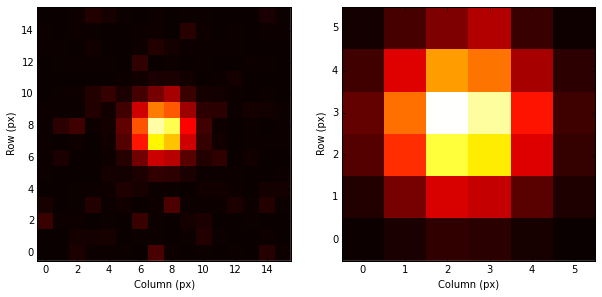

In [20]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.imshow(star_field, interpolation='none', origin='lower', cmap='hot', vmax=1000)
plt.xlabel('Column (px)')
plt.ylabel('Row (px)');

plt.subplot(1, 2, 2)

r0 = np.round(star_field.row0 + star_field.IMGSIZE / 2 - 3)
c0 = np.round(star_field.col0 + star_field.IMGSIZE / 2 - 3)
cut = ACAImage(row0=r0, col0=c0, shape=(6, 6))
plt.imshow(star_field[cut], interpolation='none', cmap='hot', origin='lower');
plt.xlabel('Column (px)')
plt.ylabel('Row (px)');

__Figure.__ _Left:_ Simulated star field. _Right_: This is to verify if star is in the center of a 6x6 readout window centered at (yag, zag).

### Star field simulator combined with star tracker###

In [21]:
kwargs = {'radius': 40., 'imgsize': 6, 'dither': dither, 'dark': d.start}

In [22]:
reload(sim)
guide = sim.simulate_guide(obc.yags.times[1::2][:500], quat, yag, zag, maxmag=maxmag, **kwargs)

In [23]:
guide.keys()

['funcs',
 'dyags',
 'imgraws',
 'quats',
 'row0s',
 'dzags',
 'bgdavgs',
 'true_zags',
 'aca_yags',
 'col0s',
 'aca_zags',
 'aca_mags',
 'true_yags',
 'stars',
 'time']

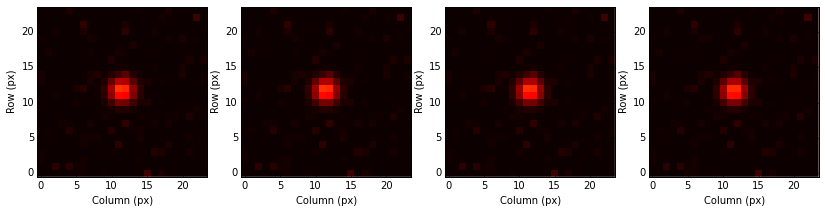

In [24]:
plt.figure(figsize=(14, 5))
start, num = 4, 4
plot_set(guide['stars'], start=start, num=num)

__Figure.__ Dictionary <code>guide</code> contains a key _stars_ to store the original star field images.

In [25]:
print('Star has been tracked. Min/Max values of row0s and col0s of ACA readout windows:')
print(guide['row0s'].min(), guide['row0s'].max(), guide['col0s'].min(), guide['col0s'].max())

print('\nMin/Max values of row0s and col0s of original star fields:')
stars_row0s = [star.row0 for star in guide['stars']]
stars_col0s = [star.col0 for star in guide['stars']]
print(np.min(stars_row0s), np.max(stars_row0s))
print(np.min(stars_col0s), np.max(stars_col0s))

Star has been tracked. Min/Max values of row0s and col0s of ACA readout windows:
(-178.0, -175.0, -321.0, -318.0)

Min/Max values of row0s and col0s of original star fields:
(-187.0, -184.0)
(-330.0, -327.0)


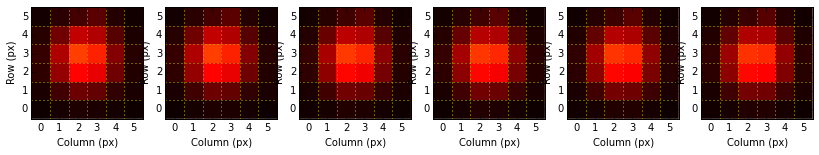

In [26]:
plt.figure(figsize=(14, 5))
start, num = 0, 6
plot_set(guide['imgraws'], start=start, num=num, grid6x6=True)

__Figure.__ Dictionary <code>guide</code> contains key _imgraws_ to store the 6x6 (8x8) images used for tracking and computing the centroids. Keys _row0s_, _col0s_ contain values defining the location of these images on ACA CCD. Note the 2-3px offset between the 'true' centroid and simulated centroid in the left-most image (image at t=0). This could be due to pointing errors, or an error on the order of imgsize/2 while simulating the star field.

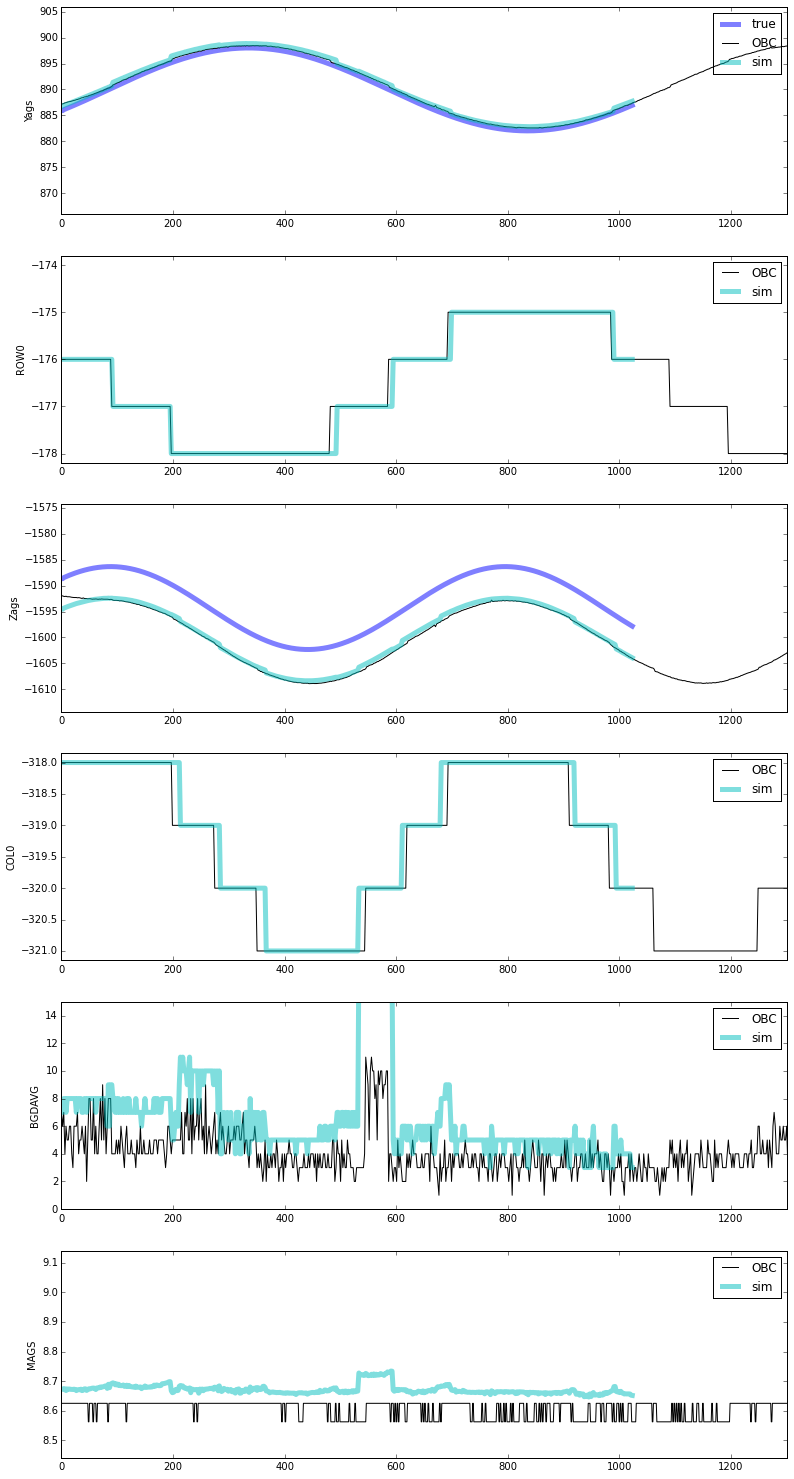

In [27]:
plot_guide_summary(guide)

__Figure.__<br>
* Simulations (cyan) match OBC telemetry (black) after adjusting (y, z) dither phases (and initial yag, zag and quat) 'by eye'.
* Simulated yags, zags and row0s, col0s (cyan) match very closely the OBC telemetry (black).
* There will be no ideal match between the simulated background and OBC's bdgavg because in simulations we use a dark current background that may differ from the real OBC data for a given obsid.
* Simulated magnitudes are fainter than OBC's values because simulated background is overestimated.
* Difference between true_zags and simulated zags is not understood: could this be due to the initial attitude error in pitch?

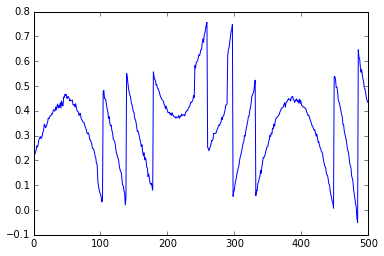

In [28]:
plt.plot(guide['true_zags'] - guide['aca_zags']);

__Figure.__ Difference in pixels between true_zags and simulated zags. Simulated zags match closely the OBC telemetry.